In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

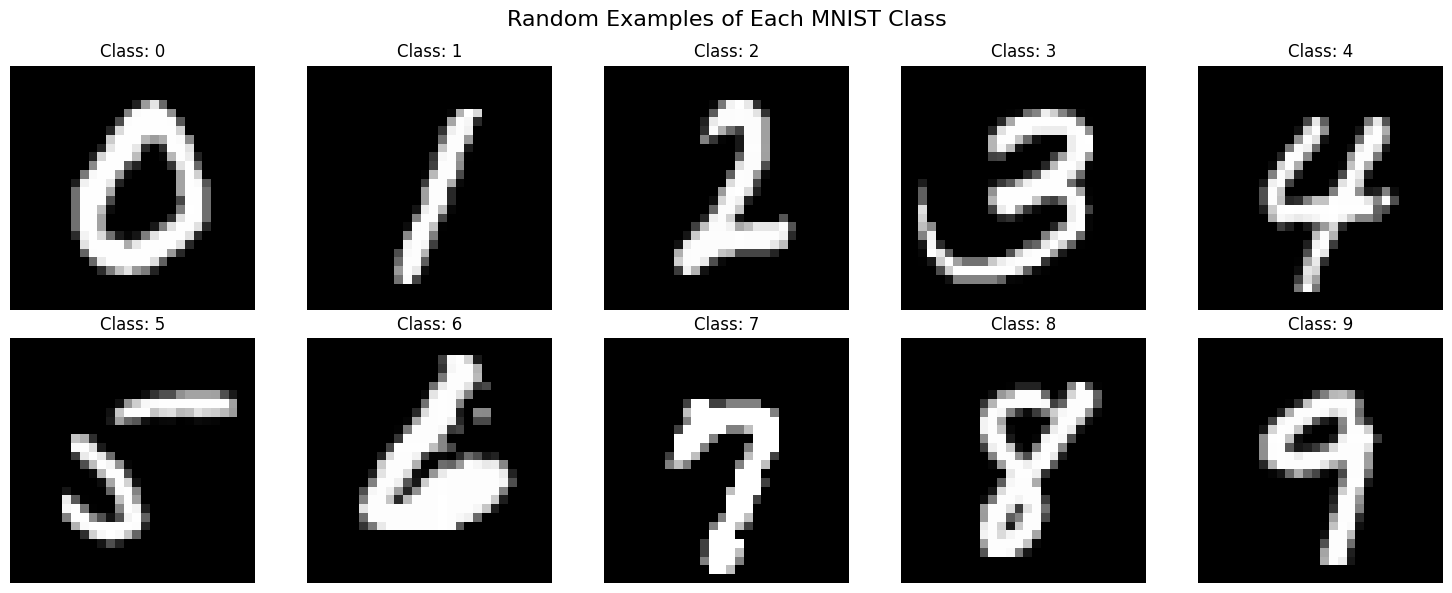

In [3]:
class_indices = {i: [] for i in range(10)}

for idx, (_, label) in enumerate(test_dataset):
    class_indices[label].append(idx)

def plot_class_examples(dataset, class_indices):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Random Examples of Each MNIST Class", fontsize=16)

    for i in range(10):
        row = i // 5
        col = i % 5
        
        # Randomly select an index for this class
        idx = random.choice(class_indices[i])
        
        # Get the image and label
        image, label = dataset[idx]
        
        # Plot the image
        axes[row, col].imshow(image.squeeze().numpy(), cmap='gray')
        axes[row, col].set_title(f"Class: {label}")
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot the examples
plot_class_examples(test_dataset, class_indices)

In [4]:
LATEND_DIMENSIONS = 16

### Encoder Class

In [5]:
class Encoder(nn.Module):
    def __init__(self, latend_dims=LATEND_DIMENSIONS):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=8, 
                      kernel_size=3,
                      padding=1), # out: BS, 8, 28, 28
            nn.Conv2d(in_channels=8, 
                      out_channels=16, 
                      kernel_size=3,
                      padding=1), # out: BS, 16, 28, 28
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*28*28, latend_dims)
        )

    def forward(self, x):
        return self.encoder(x)

### Decoder Class

In [6]:
class Decoder(nn.Module):
    def __init__(self, latend_dims=LATEND_DIMENSIONS):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latend_dims, 16*28*28),
            nn.ReLU(),
            nn.Unflatten(1, (16, 28, 28)),  # Reshape to (16, 28, 28)
            nn.ConvTranspose2d(in_channels=16, 
                               out_channels=8, 
                               kernel_size=3,
                               padding=1),  # out: BS, 8, 28, 28
            nn.ConvTranspose2d(in_channels=8, 
                               out_channels=1, 
                               kernel_size=3,
                               padding=1),  # out: BS, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 20

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Test Loss: {avg_test_loss:.4f}')

Epoch [1/20], Train Loss: 0.5573, Test Loss: 0.5188
Epoch [2/20], Train Loss: 0.5087, Test Loss: 0.5120
Epoch [3/20], Train Loss: 0.5030, Test Loss: 0.5084
Epoch [4/20], Train Loss: 0.5000, Test Loss: 0.5064
Epoch [5/20], Train Loss: 0.4980, Test Loss: 0.5044
Epoch [6/20], Train Loss: 0.4964, Test Loss: 0.5037
Epoch [7/20], Train Loss: 0.4953, Test Loss: 0.5032
Epoch [8/20], Train Loss: 0.4944, Test Loss: 0.5021
Epoch [9/20], Train Loss: 0.4936, Test Loss: 0.5019
Epoch [10/20], Train Loss: 0.4930, Test Loss: 0.5012
Epoch [11/20], Train Loss: 0.4924, Test Loss: 0.5009
Epoch [12/20], Train Loss: 0.4919, Test Loss: 0.5004
Epoch [13/20], Train Loss: 0.4915, Test Loss: 0.5007
Epoch [14/20], Train Loss: 0.4911, Test Loss: 0.5000
Epoch [15/20], Train Loss: 0.4907, Test Loss: 0.4999
Epoch [16/20], Train Loss: 0.4904, Test Loss: 0.5000
Epoch [17/20], Train Loss: 0.4901, Test Loss: 0.4996
Epoch [18/20], Train Loss: 0.4898, Test Loss: 0.4992
Epoch [19/20], Train Loss: 0.4896, Test Loss: 0.4994
Ep

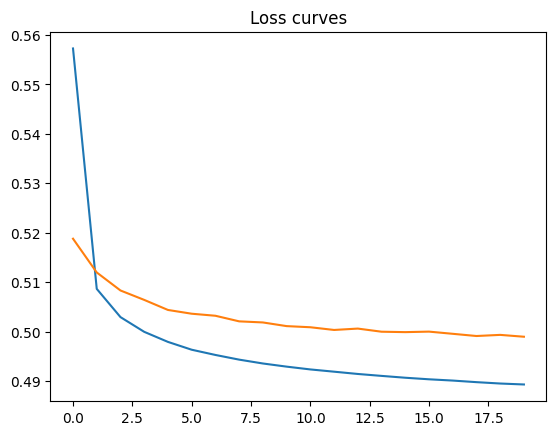

In [10]:
sns.lineplot(x=range(num_epochs), y=train_losses)
sns.lineplot(x=range(num_epochs), y=test_losses)
plt.title('Loss curves')
plt.show()

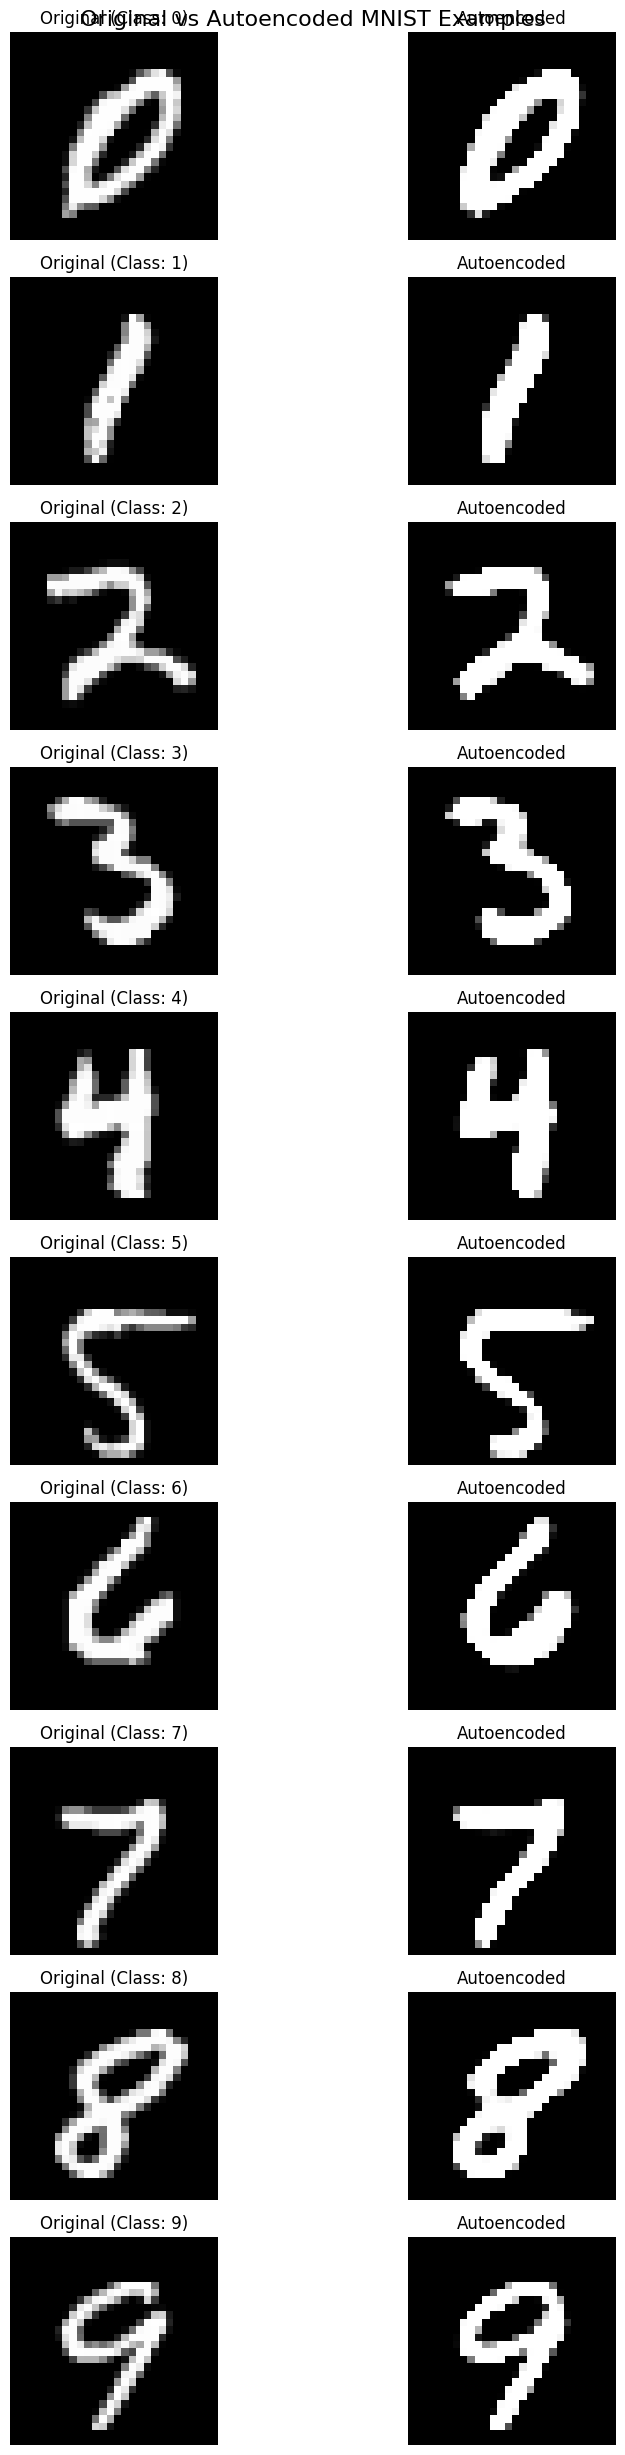

In [11]:
def plot_original_and_autoencoded(model, dataset, class_indices, device):
    model.eval()  # Set the model to evaluation mode
    
    fig, axes = plt.subplots(10, 2, figsize=(10, 25))
    fig.suptitle("Original vs Autoencoded MNIST Examples", fontsize=16)

    with torch.no_grad():
        for i in range(10):
            # Randomly select an index for this class
            idx = random.choice(class_indices[i])
            
            # Get the image and label
            image, label = dataset[idx]
            
            # Move image to the same device as the model
            image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            
            # Get the autoencoded image
            autoencoded = model(image)
            
            # Move tensors back to CPU for plotting
            image = image.cpu().squeeze()
            autoencoded = autoencoded.cpu().squeeze()
            
            # Plot original image
            axes[i, 0].imshow(image.numpy(), cmap='gray')
            axes[i, 0].set_title(f"Original (Class: {label})")
            axes[i, 0].axis('off')
            
            # Plot autoencoded image
            axes[i, 1].imshow(autoencoded.numpy(), cmap='gray')
            axes[i, 1].set_title("Autoencoded")
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming you have your model, test_dataset, and class_indices already defined
# And assuming your model and data are on the same device (CPU or GPU)

device = next(model.parameters()).device  # Get the device of the model

# Plot the examples
plot_original_and_autoencoded(model, test_dataset, class_indices, device)

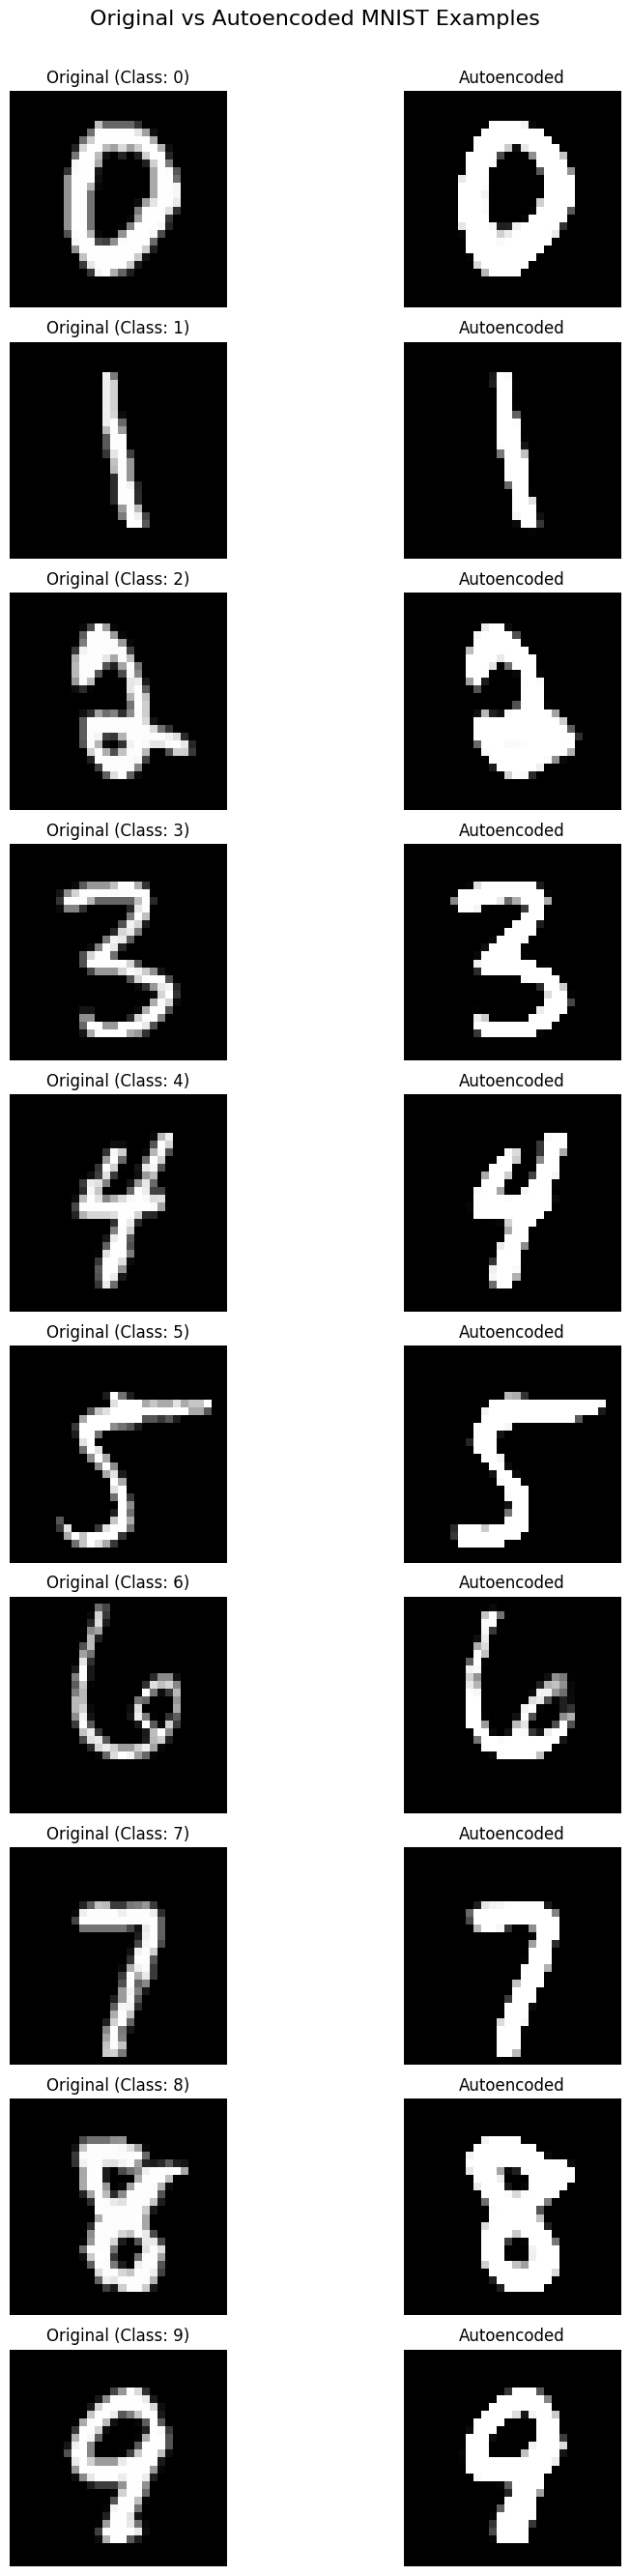

In [12]:
def plot_original_and_autoencoded(model, dataset, class_indices, device):
    model.eval()  # Set the model to evaluation mode
    
    fig, axes = plt.subplots(10, 2, figsize=(10, 28))  # Increased figure height
    fig.suptitle("Original vs Autoencoded MNIST Examples", fontsize=16, y=0.95)  # Adjusted title position
    
    with torch.no_grad():
        for i in range(10):
            # Randomly select an index for this class
            idx = random.choice(class_indices[i])
            
            # Get the image and label
            image, label = dataset[idx]
            
            # Move image to the same device as the model
            image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            
            # Get the autoencoded image
            autoencoded = model(image)
            
            # Move tensors back to CPU for plotting
            image = image.cpu().squeeze()
            autoencoded = autoencoded.cpu().squeeze()
            
            # Plot original image
            axes[i, 0].imshow(image.numpy(), cmap='gray')
            axes[i, 0].set_title(f"Original (Class: {label})")
            axes[i, 0].axis('off')
            
            # Plot autoencoded image
            axes[i, 1].imshow(autoencoded.numpy(), cmap='gray')
            axes[i, 1].set_title("Autoencoded")
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust the top margin
    plt.show()

# Assuming you have your model, test_dataset, and class_indices already defined
# And assuming your model and data are on the same device (CPU or GPU)
device = next(model.parameters()).device  # Get the device of the model

# Plot the examples
plot_original_and_autoencoded(model, test_dataset, class_indices, device)